## This notebook tests the Steady State Heat solver

-----------

2D, Steady Heat Equation with no variation in the x direction

\\[
0 = k \frac{\partial^2 T}{\partial y^2}+H
\\]

\\[
\frac{\partial T}{\partial x} = 0
\\]

with $x,y : [0,1]$


Two models are presented below, each with an analytic solution that the numerical results are tested against.

The general solution is:

$ T = -\frac{h}{2 k}y^{2} + c_{0}y + c_{1} $

where $c_{0}, c_{1}$ are arbitrary constants found by applying each model's boundary conditions

In [1]:
import underworld as uw
import glucifer
import numpy as np
rank = uw.rank()

# depth range
ymin = 0.0
ymax = 1.0

# build mesh and fields
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (10, 20), 
                                 minCoord    = (0., ymin), 
                                 maxCoord    = (1., ymax))

tField    = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1, dataType='double')
topWall = mesh.specialSets['MaxJ_VertexSet']
bottomWall = mesh.specialSets['MinJ_VertexSet']

Model 1) 
------------
2D, Steady State Heat Equation with Dirichlet BC at top and bottom boundary.

$T(x,y=1) = T_{o}$

$ T(x,y=0) = T_{b} $

------

Effectively a 1D problem in $y$-axis - arbitrary constants are:

$c_{0} = T_{o} + \frac{h}{2 k} - c_{1}$

$c_{1} = T_{b}$


In [2]:
# # analytic solution definitions
def exactFunc(y, h, k, c0, c1):
     return -h/(2*k)*y*y + c0*y + c1

def exactDeriv(y, h, k, c0):
    return -h/k*y + c0

In [3]:
# Model parameters
To = 8.0   # top surface temperature
Td = 4.0   # bottom surface temperature
k = 1.0    # diffusivity
h = 1.0e1  # heat production, source term

# arbitrary constant given the 2 dirichlet conditions
c1 = Td 
c0 = To + h/(2.0*k) - c1

In [4]:
# set boundary conditions
for ii in topWall:
    tField.data[ii] = To
for ii in bottomWall:
    tField.data[ii] = Td

# flag boundary conditions
bc = uw.conditions.DirichletCondition(tField, indexSetsPerDof=(topWall+bottomWall) )

# define heat eq. system
ss = uw.systems.SteadyStateHeat( temperatureField  = tField,
                                 fn_diffusivity = k,
                                 fn_heating     = h,
                                 conditions     = [bc] )

### optional visuals
# fig = glucifer.Figure()
# fig.append(glucifer.objects.Surface(mesh=mesh, fn=tField, colours=('blue white red')) )
# fig.save_image('./initial.png')

In [5]:
solver = uw.systems.Solver(ss)
solver.solve()
### option visuals
# fig.save_image('./final.png')

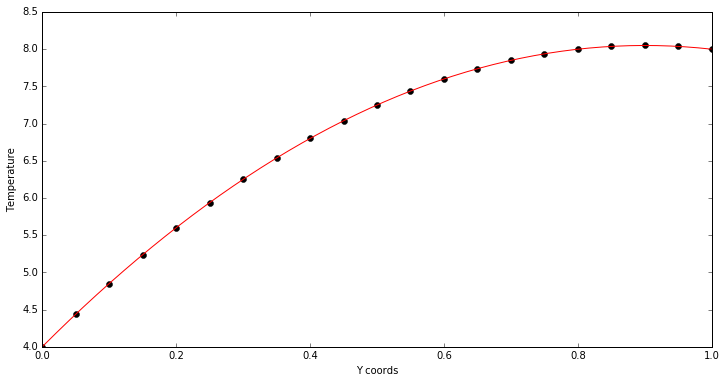

Numerical flux at y =  0.0 is 8.74955272418
Exact flux at y= 0.0 is 9.0

|T - T_analytic|_2 = 3.223e-04

|T|_2 = 3.167e+01

Rel. error = 1.018e-05


In [6]:
# create numpy arrays for analytics
yvals       = np.zeros(len(mesh.specialSets['MinI_VertexSet'].data))
ycoord      = np.zeros_like(yvals)
yexact_k_v1 = np.zeros_like(yvals)

ids = mesh.specialSets['MinI_VertexSet']
yvals[:] = tField.evaluate(ids).T

ycoord = tField.mesh.data[ids.data,[1]]
yexact_k_v1 = exactFunc(ycoord, h, k, c0, c1)

# print "The numerics: ",yvals
# print "The numerics: ",yexact_k_v1

abserr = uw.utils._nps_2norm(yexact_k_v1 - yvals)
mag = uw.utils._nps_2norm(yexact_k_v1)
relerr = abserr / mag

from mpi4py import MPI
comm = MPI.COMM_WORLD
# assuming order in the allgather is the same
coords = comm.allgather(ycoord)
numerical = comm.allgather(yvals)


if rank == 0:
    # build matplot lib graph of result only on proc 0

    # 1st build exact solution hiRes
    big = np.linspace(ymin,ymax)
    cool = exactFunc(big, h, k, c0, c1)

    %matplotlib inline
    import matplotlib.pyplot as pyplot
    import matplotlib.pylab as pylab
    pylab.rcParams[ 'figure.figsize'] = 12, 6
    pyplot.plot(coords, numerical, 'o', color = 'black', label='numerical') 
    pyplot.plot(big, cool, color = 'red', label="exact") 
    pyplot.xlabel('Y coords')
    pyplot.ylabel('Temperature')
    pyplot.show()

if rank == 0:
    threshold = 3.0e-4
    yspot = ymin
    print "Numerical flux at y = " ,yspot,"is", tField.fn_gradient.evaluate([0.2,yspot])[0][1]
    print "Exact flux at y=" ,yspot,"is", exactDeriv(yspot,h,k,c0)
    print "\n|T - T_analytic|_2 = {0:.3e}\n\n|T|_2 = {1:.3e}\n".format(abserr, mag)
    print "Rel. error = {0:.3e}".format(relerr)
    if relerr > threshold:
        raise RuntimeError("The numerical solution is outside the error threshold of the analytic solution." \
                           "The Relative error was ", relerr," the threshold is ", threshold)  
        import sys
        sys.exit(1)

-------

Model Setup
-----------

2D, Heat Equation with a Dirichlet BC (top) and a Neumann BC (bottom).

$T(y=1) = T_{o}$

$ \nabla{T}_{y=0} = \left[\,0,\,f\,\right] $


------

Effectively a 1D problem in $y$-axis - arbitrary constants are:

$c_{0} = f $

$c_{1} = T_{o} + \frac{h}{2 k} - c_{0} $


In [7]:
To = 8.0       # surface temperature
k = 1.0        # diffusivity
h = 1.0e1      # heat production, source term
f = [0.0,3.0]  # (dT_dx,dT_dy)

# analytic solution definitions
# 1 dirichlet conditions (top) + 1 neumann (bottom)
c0 = f[1]
c1 = To + h/(2.0*k) - c0

In [8]:
for ii in topWall:
    tField.data[ii] = To

# define neumann condition
nbc = uw.conditions.NeumannCondition( flux=f, 
                                      variable=tField, 
                                      nodeIndexSet=(bottomWall) )

bc = uw.conditions.DirichletCondition(tField, indexSetsPerDof=(topWall) )

# define heat eq. system
ss = uw.systems.SteadyStateHeat( temperatureField  = tField,
                                 fn_diffusivity = k,
                                 fn_heating     = h,
                                 conditions     = [bc, nbc] ) 

### optional visuals
# fig = glucifer.Figure()
# fig.append(glucifer.objects.Surface(mesh=mesh, fn=tField, colours=('blue white red')) )
# fig.save_image('./initial.png')

In [9]:
solver = uw.systems.Solver(ss)
solver.solve()
### option visuals
# fig.save_image('./final.png')

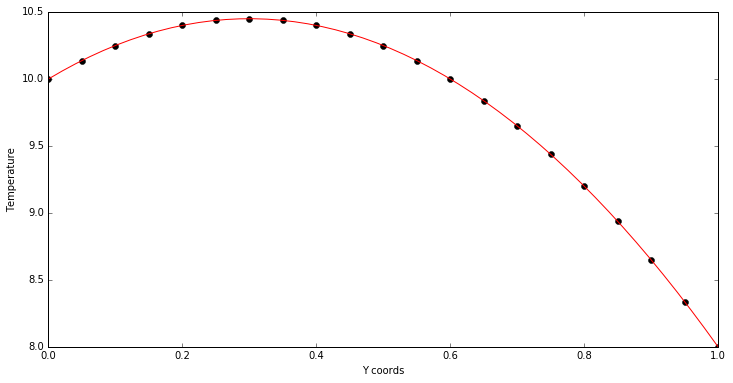

Numerical flux at y =  0.0 is 2.75007276863
Exact flux at y= 0.0 is 3.0

|T - T_analytic|_2 = 6.621e-04

|T|_2 = 4.500e+01

Rel. error = 1.472e-05


In [10]:
# create numpy arrays for analytics
yvals       = np.zeros(len(mesh.specialSets['MinI_VertexSet'].data))
ycoord      = np.zeros_like(yvals)
yexact_k_v1 = np.zeros_like(yvals)

ids = mesh.specialSets['MinI_VertexSet']
yvals[:] = tField.evaluate(ids).T

ycoord = tField.mesh.data[ids.data,[1]]
yexact_k_v1 = exactFunc(ycoord, h, k, c0, c1)

# print "The numerics: ",yvals
# print "The numerics: ",yexact_k_v1

abserr = uw.utils._nps_2norm(yexact_k_v1 - yvals)
mag = uw.utils._nps_2norm(yexact_k_v1)
relerr = abserr / mag

from mpi4py import MPI
comm = MPI.COMM_WORLD
# assuming order in the allgather is the same
coords = comm.allgather(ycoord)
numerical = comm.allgather(yvals)


if rank == 0:
    # build matplot lib graph of result only on proc 0

    # 1st build exact solution hiRes
    big = np.linspace(ymin,ymax)
    cool = exactFunc(big, h, k, c0, c1)

    %matplotlib inline
    import matplotlib.pyplot as pyplot
    import matplotlib.pylab as pylab
    pylab.rcParams[ 'figure.figsize'] = 12, 6
    pyplot.plot(coords, numerical, 'o', color = 'black', label='numerical') 
    pyplot.plot(big, cool, color = 'red', label="exact") 
    pyplot.xlabel('Y coords')
    pyplot.ylabel('Temperature')
    pyplot.show()

if rank == 0:
    threshold = 3.0e-4
    yspot = ymin
    print "Numerical flux at y = " ,yspot,"is", tField.fn_gradient.evaluate([0.2,yspot])[0][1]
    print "Exact flux at y=" ,yspot,"is", exactDeriv(yspot,h,k,c0)
    print "\n|T - T_analytic|_2 = {0:.3e}\n\n|T|_2 = {1:.3e}\n".format(abserr, mag)
    print "Rel. error = {0:.3e}".format(relerr)
    if relerr > threshold:
        raise RuntimeError("The numerical solution is outside the error threshold of the analytic solution." \
                           "The Relative error was ", relerr," the threshold is ", threshold)  
        import sys
        sys.exit(1)